In [1]:
#!/usr/bin/python3
# coding: utf-8
# Tokyo

In [22]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import pandas as pd
import sys
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int

In [23]:
# 東京都の OpenData を参照する
patients_file = "130001_tokyo_covid19_patients.csv"
patients_uri = "https://stopcovid19.metro.tokyo.lg.jp/data/"
download_if_needed(patients_uri, patients_file)

In [24]:
patients = []
# CSVデータを整形する
with codecs.open(patients_file, encoding="utf-8") as f:
    l = f.readline()
    while l:
        l = f.readline().replace("\r\n", "")
        arr = l.split(',')
        if len(arr) == 16:
            patients.append(
                [
                    code2int(arr[0]), # No
                    code2int(arr[1]), # code
                    arr[2], # state
                    arr[4], # date
                    arr[5], # day of week
                    arr[7], # live in
                    age2int(arr[8]), # age
                    arr[9], # sex
                    arr[15] # discharge
                ]
            )

print("Total: {}".format(len(patients)))
# 先頭３つのデータは飛ばす
patients = patients[3:]
#print("Total: {}".format(len(patients)))

Total: 26727


In [25]:
# Pandas DataFrame を作成する
df = pd.DataFrame(patients, columns=['No', 'Code', 'State', 'Date', 'DoW', 'LiveIn', 'Age', 'Sex', 'Discharge'])

In [26]:
# Daily の新規感染者を集計する
daily_new = df.groupby('Date').size()
print("Daily New: {}".format(daily_new[-1]))
# duration
frm_date = daily_new.index[0]
end_date = daily_new.index[-1]
print("From: {} To: {}".format(frm_date, end_date))
# moving average by week
ave_mov_days = 7
# 移動平均を算出する
mov_mean = daily_new.rolling(ave_mov_days).mean()

Daily New: 177
From: 2020-02-13 To: 2020-10-06


In [27]:
# 4 weeks later
xbins = [dt.strptime(x, "%Y-%m-%d") for x in daily_new.index]
days2pred = 2 * ave_mov_days # 2 weeks
# 2週間先の日付列を取得する
two_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
xbins_pred = xbins.copy()
xbins_pred.extend(two_weeks_later)

X = np.arange(0, len(daily_new.index.values))[:, np.newaxis]
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]
y_gpr = get_gpr_predict(X, daily_new.values, X_pred, 80, 10, 200)

y 0 val = 177.


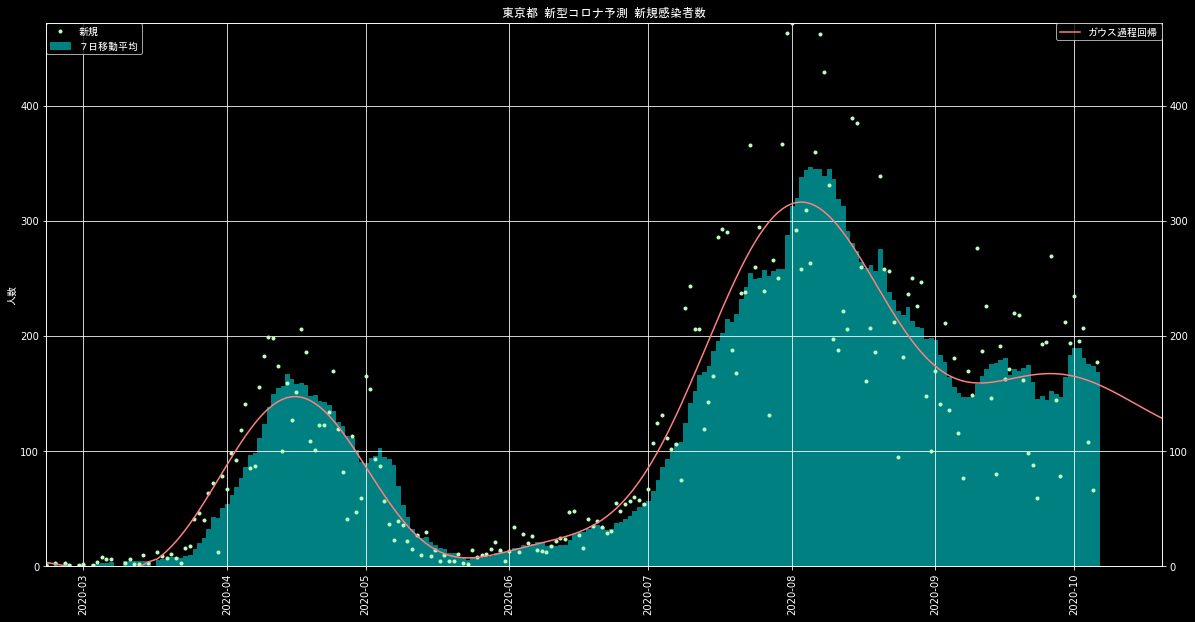

In [28]:
fig, ax = create_basic_plot_figure()
ymax = max(daily_new)
plt.title('東京都 新型コロナ予測 新規感染者数', fontname=FONT_NAME)
plt.xlim(xbins_pred[ave_mov_days], xbins_pred[-1])
plt.ylim(0, ymax)
plt.plot(xbins, daily_new,  '.', linewidth=1, color='#c0ffc0')
plt.bar(xbins, mov_mean, color='#008080', edgecolor='#008080', alpha=1)
plt.legend(labels=["新規", "７日移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
ax2 = ax.twinx()
plt.plot(xbins_pred, y_gpr, '-', linewidth=1.5, color='#ff8080')
plt.ylim(0, ymax)
plt.legend(labels=["ガウス過程回帰"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
show_and_clear(fig, "images/tokyo.jpg")

In [29]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body = "東京都 新型コロナ予測 新規感染者数(東京都 " + today_str + " 時点)"
tw = get_twitter()
tweet_with_image(tw, "images/tokyo.jpg", tw_body)

In [30]:
# Github JSON データ
github_uri = "https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/"
raw_files = dict(
    pos_rate = "positive_rate.json", # 陽性率
    pos_detail = "daily_positive_detail.json", # 経路情報
)

for k, v in raw_files.items():
    download_if_needed(github_uri, v)

In [31]:
keys_rate = [
    #"diagnosed_date",
    "positive_count",
    "negative_count",
    "positive_rate",
    "weekly_average_diagnosed_count",
    "pcr_positive_count",
    "pcr_negative_count",
    "antigen_positive_count",
    "antigen_negative_count"
]

In [32]:
pos_rate_np = json2nparr(keys_rate, raw_files['pos_rate'])
# 検査件数
tests_cnt = pos_rate_np[:, 1] + pos_rate_np[:, 2]

positive_rate.json 更新日: 2020/10/6 19:15


In [33]:
xbins = pos_rate_np[:, 0]
two_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
xbins_pred = xbins.tolist()
xbins_pred.extend(two_weeks_later)
X = np.arange(0, len(pos_rate_np[:, 0]))[:, np.newaxis]
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]

y_test = get_gpr_predict(X, tests_cnt, X_pred, 1.0, 1.0, 1.0)
y_rate = get_gpr_predict(X, pos_rate_np[:, 3], X_pred)

y 0 val = 3416.
y 0 val = 3.3.


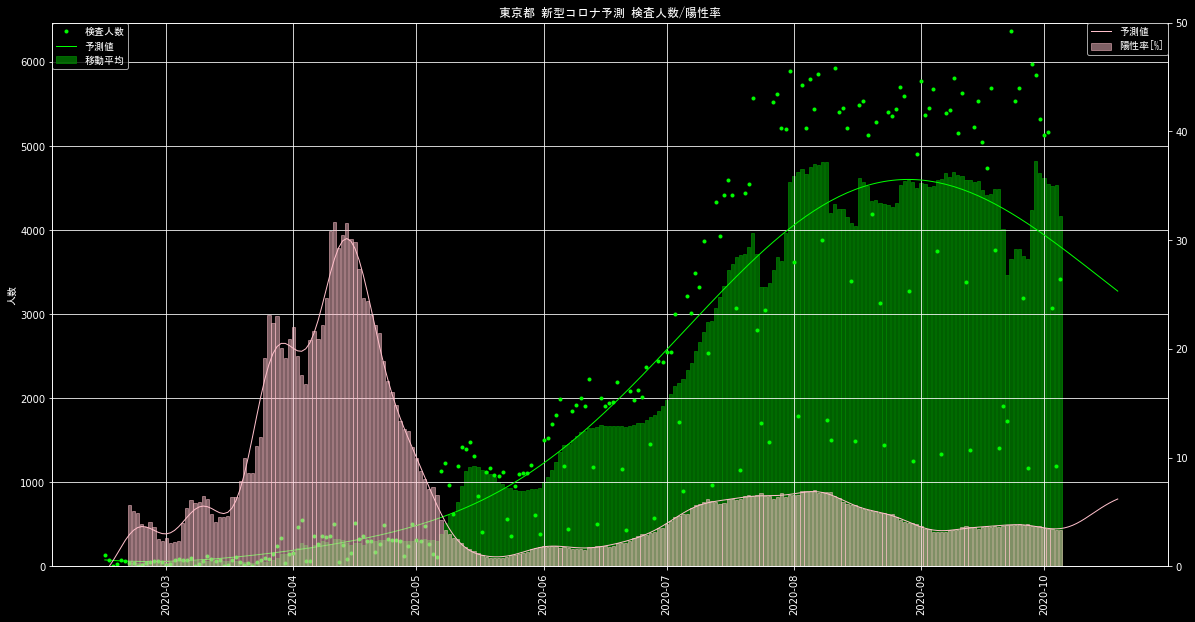

In [34]:
fig, ax = create_basic_plot_figure()
plt.title('東京都 新型コロナ予測 検査人数/陽性率', fontname=FONT_NAME)
plt.ylabel('人数', fontname=FONT_NAME)
plt.ylim(0, max(tests_cnt)+100)
plt.plot(xbins, tests_cnt, '.', linewidth=1.5, color='#00ff00')
plt.plot(xbins_pred, y_test, '-', color='#00ff00', linewidth=1)
plt.bar(xbins, pos_rate_np[:, 4], color='#008000', edgecolor='#008000', alpha=.75)
plt.legend(labels=["検査人数", "予測値", "移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
ax2 = ax.twinx()
plt.ylim(0, 50)
ax2.plot(xbins_pred, y_rate, '-', color='pink', linewidth=1)
ax2.bar(xbins, pos_rate_np[:, 3], color='pink', edgecolor='pink', alpha=.5)
plt.legend(labels=["予測値", "陽性率[%]"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
show_and_clear(fig, "images/tokyo-rate.jpg")

In [35]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body = "東京都 新型コロナ予測 検査人数/陽性率(東京都 " + today_str + " 時点)"
tweet_with_image(tw, "images/tokyo-rate.jpg", tw_body)

In [36]:
keys_detail = [
    #"diagnosed_date",
    "count",
    "missing_count",
    "reported_count",
    "weekly_gain_ratio",
    "untracked_percent",
    "weekly_average_count",
    "weekly_average_untracked_count",
    "weekly_average_untracked_increse_percent"]

In [37]:
pos_detail_np = json2nparr(keys_detail, raw_files['pos_detail'])
xbins = pos_detail_np[:, 0]

daily_positive_detail.json 更新日: 2020/10/6 19:15


In [38]:
two_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
xbins_pred = xbins.tolist()
xbins_pred.extend(two_weeks_later)
X = np.arange(0, len(pos_detail_np[:, 0]))[:, np.newaxis]
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]

In [39]:
y_un_rate = get_gpr_predict(X, pos_detail_np[:, 5], X_pred, 1.0, 1.0, 1.0)
y_cases = get_gpr_predict(X, pos_detail_np[:, 1], X_pred)
y_untrack = get_gpr_predict(X, pos_detail_np[:, 2], X_pred)

y 0 val = 53.8.
y 0 val = 177.
y 0 val = 113.


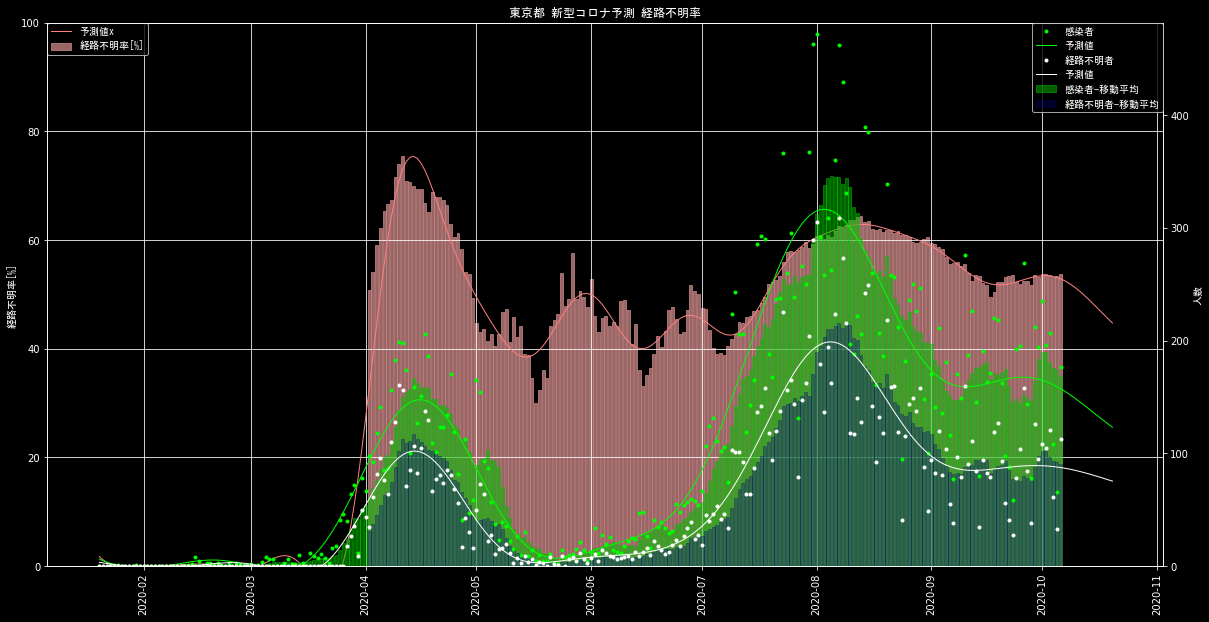

In [40]:
fig, ax = create_basic_plot_figure()
plt.title('東京都 新型コロナ予測 経路不明率', fontname=FONT_NAME)
plt.ylim(0, 100)
plt.ylabel('経路不明率[%]', fontname=FONT_NAME)
plt.plot(xbins_pred, y_un_rate, '-', color='#ff8080', linewidth=1)
plt.bar(xbins, pos_detail_np[:, 5], color='#c08080', edgecolor='#c08080', alpha=.8)
plt.legend(labels=["予測値x", "経路不明率[%]"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
ax2 = ax.twinx()
plt.ylim(0, np.max(pos_detail_np[:, 1])+10)
plt.ylabel('人数', fontname=FONT_NAME)
ax2.plot(xbins, pos_detail_np[:, 1], '.', color='#00ff00', label='感染者')
ax2.plot(xbins_pred, y_cases, '-', color='#00ff00', linewidth=1, label='予測値')
ax2.plot(xbins, pos_detail_np[:, 2], '.', color='white', label="経路不明者")
ax2.plot(xbins_pred, y_untrack, '-', color='white', linewidth=1, label='予測値')
ax2.bar(xbins, moving_average(pos_detail_np[:, 1]), color='#00c000', edgecolor='#00c000', alpha=.5, label="感染者-移動平均")
ax2.bar(xbins, pos_detail_np[:, 7], color='#000080', edgecolor='#000080', alpha=.3, label="経路不明者-移動平均")
plt.legend(loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
show_and_clear(fig, "images/tokyo-track.jpg")

In [41]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body = "東京都 新型コロナ予測 経路不明率(東京都 " + today_str + " 時点)"
tweet_with_image(tw, "images/tokyo-track.jpg", tw_body)